In [1]:
from pytorch_tools import CreateDataset, train_model_cls, train_model_reg, plot_metrics

## binary classification

In [2]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/Module_1_Lecture_2_Class_Spaceship_Titanic.csv')
df = df.set_index('PassengerId')

TARGET = 'Transported'
FEATURES = [col for col in df.columns if col != TARGET]

imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy='median')
imputer.fit(df[imputer_cols])
df[imputer_cols] = imputer.transform(df[imputer_cols])

df["HomePlanet"].fillna('Gallifrey', inplace=True)
df["Destination"].fillna('Skaro', inplace=True)

df['CryoSleep_is_missing'] = df['CryoSleep'].isna().astype(int)
df['VIP_is_missing'] = df['VIP'].isna().astype(int)

df["CryoSleep"].fillna(False, inplace=True)
df["VIP"].fillna(False, inplace=True)

df["CryoSleep"] = df["CryoSleep"].astype(int)
df["VIP"] = df["VIP"].astype(int)

dummies = pd.get_dummies(df.loc[:, ['HomePlanet', 'Destination']], dtype=int)

df = pd.concat([df, dummies], axis=1)
df.drop(columns=['HomePlanet', 'Destination'], inplace=True)

df[TARGET] = df[TARGET].astype(int)

df.drop(["Name" ,"Cabin"] , axis=1 ,inplace = True)

In [4]:
X = df.drop(TARGET , axis =1 ).values
y = df[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.33, stratify = y)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [5]:
train_dataset = CreateDataset(X_train, y_train, scaler='StandardScaler')
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=len(X_train),
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=len(X_test),
                              num_workers=0
                             )

In [6]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

In [7]:
input_dim = X_train.shape[1]
model = Net(input_dim)
parameters = list(model.parameters())

criterion = nn.BCELoss()
optimizer = optim.SGD(parameters, lr=0.01)

In [8]:
parameters

[Parameter containing:
 tensor([[ 0.0296,  0.0175, -0.0864, -0.2049,  0.0789,  0.0626,  0.0535, -0.1282,
           0.1581,  0.0450,  0.0226, -0.1519,  0.0695,  0.1674,  0.0893,  0.1726,
           0.1240, -0.2120]], requires_grad=True),
 Parameter containing:
 tensor([0.2211], requires_grad=True)]

In [11]:
metrics, model = train_model_cls(
    num_classes=2,
    num_epoch=30,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    model=model,
    criterion=criterion,
    optimizer=optimizer
)

Epoch [10/30] Train Loss: 0.6627 Acc: 0.6226 Rec: 0.7099 Prec: 0.6072
Epoch [20/30] Train Loss: 0.6540 Acc: 0.6233 Rec: 0.7027 Prec: 0.6092
Epoch [30/30] Train Loss: 0.6459 Acc: 0.6257 Rec: 0.7000 Prec: 0.6123


In [12]:
with torch.no_grad():
    y_pred = model(X_test).squeeze().numpy().round()

accuracy_score(y_test, y_pred)

0.7340536772394562

In [13]:
parameters

[Parameter containing:
 tensor([[ 0.1286,  0.0003, -0.0840, -0.2420,  0.0940,  0.0566,  0.0032, -0.1583,
           0.1426,  0.0382, -0.0224, -0.0923,  0.0626,  0.1625,  0.0964,  0.1462,
           0.1068, -0.1962]], requires_grad=True),
 Parameter containing:
 tensor([0.1983], requires_grad=True)]

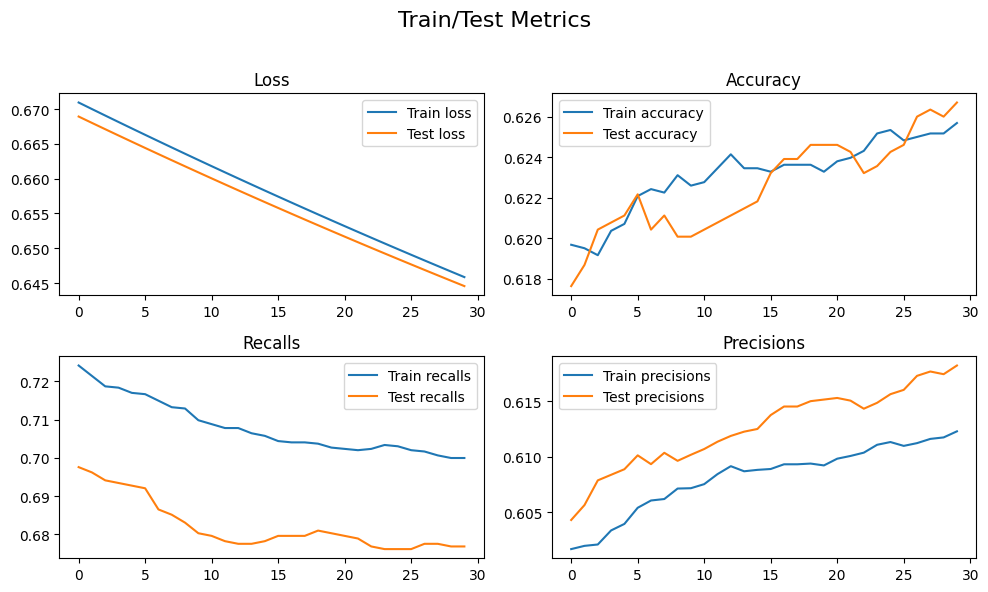

In [14]:
plot_metrics(metrics)

## multyclass classification

In [2]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/Module_2_Lecture_2_Class_penguins.csv')
df = df.dropna().reset_index(drop=True)
features = ['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
df = df.loc[:, features]
df.loc[df['species']=='Adelie', 'species']=0
df.loc[df['species']=='Gentoo', 'species']=1
df.loc[df['species']=='Chinstrap', 'species']=2
df = df.apply(pd.to_numeric)

In [4]:
X = df.drop('species', axis =1).values
y = df['species'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size =0.33, stratify=y)

X_train = torch.Tensor(X_train).float()
y_train = torch.Tensor(y_train).long()
X_test = torch.Tensor(X_test).float()
y_test = torch.Tensor(y_test).long()

In [5]:
train_dataset = CreateDataset(X_train, y_train, scaler='StandardScaler')
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=20,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=20,
                              num_workers=0
                             )

In [6]:
train_dataset.scaler

StandardScaler()

In [7]:
num_classes = len(np.unique(y_train))

In [8]:
class Net(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim=20, out_dim=3):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            
            nn.Linear(in_dim, hidden_dim),
            torch.nn.ReLU(),
            
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax()
        )    
        
    def forward(self, x):
        output = self.features(x)
        return output

In [9]:
model = Net(X_train.shape[1], 20, num_classes)
parameters = list(model.parameters())

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(parameters, lr=0.01)

In [10]:
metrics, model = train_model_cls(
    num_classes=num_classes,
    num_epoch=100,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    model=model,
    criterion=criterion,
    optimizer=optimizer
)

Epoch [10/100] Train Loss: 0.9978 Acc: 0.6608 Rec: 0.6608 Prec: 0.5301
Epoch [20/100] Train Loss: 0.8906 Acc: 0.6873 Rec: 0.6873 Prec: 0.5679
Epoch [30/100] Train Loss: 0.8196 Acc: 0.6910 Rec: 0.6910 Prec: 0.5744
Epoch [40/100] Train Loss: 0.7777 Acc: 0.6910 Rec: 0.6910 Prec: 0.5713
Epoch [50/100] Train Loss: 0.7493 Acc: 0.6910 Rec: 0.6910 Prec: 0.5713
Epoch [60/100] Train Loss: 0.7255 Acc: 0.7150 Rec: 0.7150 Prec: 0.6988
Epoch [70/100] Train Loss: 0.7028 Acc: 0.8595 Rec: 0.8595 Prec: 0.9089
Epoch [80/100] Train Loss: 0.6810 Acc: 0.8903 Rec: 0.8903 Prec: 0.9251
Epoch [90/100] Train Loss: 0.6619 Acc: 0.9496 Rec: 0.9496 Prec: 0.9765
Epoch [100/100] Train Loss: 0.6464 Acc: 0.9555 Rec: 0.9555 Prec: 0.9795


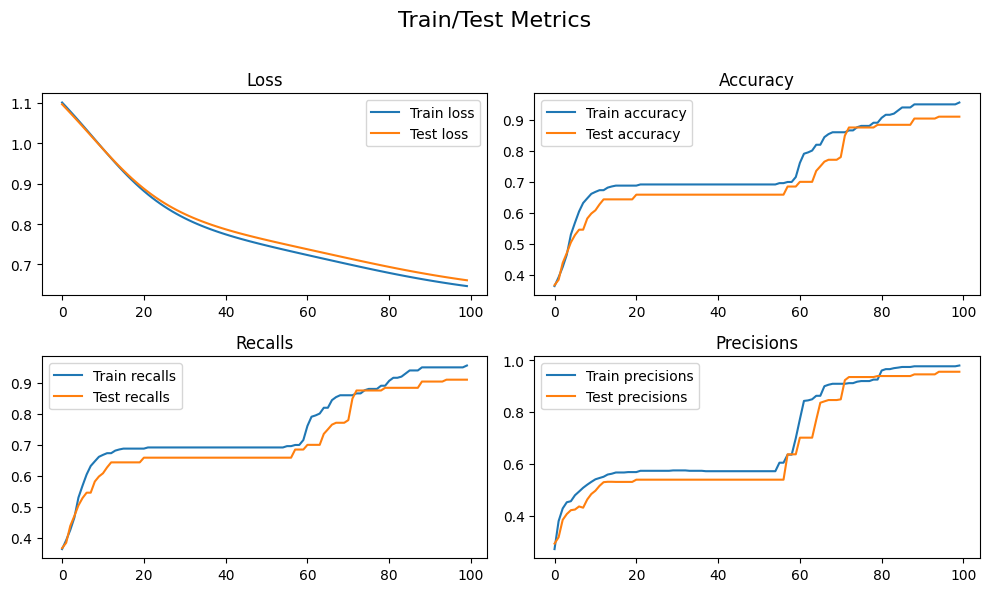

In [11]:
plot_metrics(metrics)

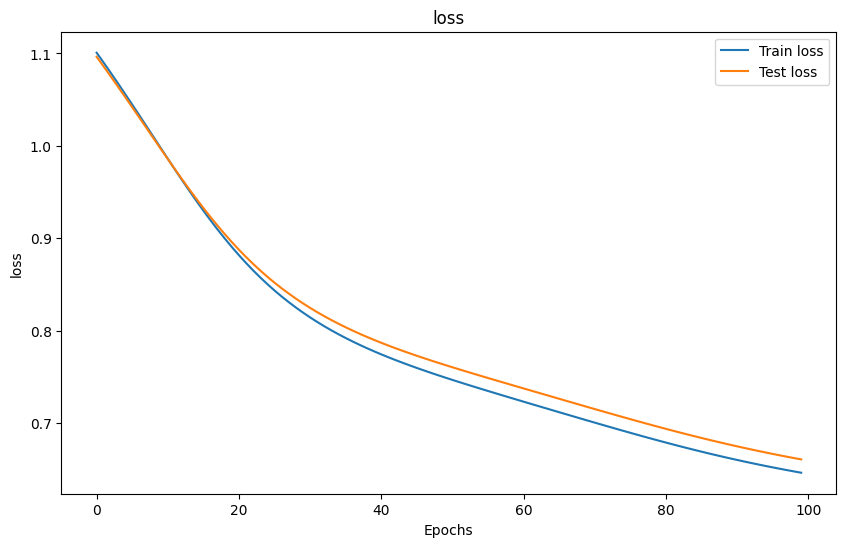

In [12]:
plot_metrics(metrics, 'loss')

## regression

In [13]:
from dataclasses import dataclass

import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [14]:
data_path = 'data/Module_2_Lecture_2_Class_bigmart_data.csv'
data = pd.read_csv(data_path)
data['Outlet_Establishment_Year'] = 2013 - data['Outlet_Establishment_Year']
data['Item_Visibility'] = (data['Item_Visibility']
                           .mask(data['Item_Visibility'].eq(0), np.nan))

data['Item_Visibility_Avg'] = (data
                               .groupby(['Item_Type',
                                         'Outlet_Type'])['Item_Visibility']
                               .transform('mean'))

data['Item_Visibility'] = (
    data['Item_Visibility'].fillna(data['Item_Visibility_Avg']))

data['Item_Visibility_Ratio'] = (
    data['Item_Visibility'] / data['Item_Visibility_Avg'])

data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'})

data['Item_Identifier_Type'] = data['Item_Identifier'].str[:2]
data_num = data.select_dtypes(include=np.number)
data_cat = data.select_dtypes(include='object')

In [15]:
X_train_num, X_test_num, X_train_cat,  X_test_cat, y_train, y_test = (
    train_test_split(
        data_num.drop(['Item_Outlet_Sales',
                       'Item_Visibility_Avg'], axis=1).values,
        data_cat.drop('Item_Identifier', axis=1).values,
        data['Item_Outlet_Sales'].values,
        test_size=0.2,
        random_state=42))

num_imputer = SimpleImputer().set_output(transform='pandas')
X_train_num = num_imputer.fit_transform(X_train_num)
X_test_num = num_imputer.transform(X_test_num)

cat_imputer = SimpleImputer(strategy='most_frequent').set_output(transform='pandas')
X_train_cat = cat_imputer.fit_transform(X_train_cat)
X_test_cat = cat_imputer.transform(X_test_cat)
enc_auto = TargetEncoder(random_state=42).set_output(transform='pandas')
X_train_cat = enc_auto.fit_transform(X_train_cat, y_train)
X_test_cat = enc_auto.transform(X_test_cat)

X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

In [16]:
train_dataset = CreateDataset(X_train, y_train)
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=20,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=20,
                              num_workers=0
                             )

In [17]:
class LinearModel(torch.nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            nn.Linear(in_dim, 256),
            torch.nn.ReLU(),
            
            nn.Linear(256, 128),
            torch.nn.ReLU(),
            
            nn.Linear(128, 64),
            torch.nn.ReLU(),
            
            nn.Linear(64, out_dim),
        )
    
        
    def forward(self, x):
        output = self.features(x)
        return output

In [18]:
model = LinearModel(in_dim=X_train.shape[1], out_dim=1)
  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [19]:
metrics, model = train_model_reg(num_epoch=100,
                    train_dataloader = train_dataloader,
                    test_dataloader = test_dataloader,
                    model=model,
                    criterion=criterion,
                    optimizer=optimizer,
                    )

Epoch [10/100] Train Loss: 1269182.5623 MSE: 1269182.5623 MAE: 815.8626 RMSE: 1126.5800
Epoch [20/100] Train Loss: 1235840.3529 MSE: 1235840.3529 MAE: 794.2392 RMSE: 1111.6836
Epoch [30/100] Train Loss: 1219341.8393 MSE: 1219341.8393 MAE: 786.7691 RMSE: 1104.2381
Epoch [40/100] Train Loss: 1206099.3383 MSE: 1206099.3383 MAE: 780.7334 RMSE: 1098.2255
Epoch [50/100] Train Loss: 1195071.0055 MSE: 1195071.0055 MAE: 775.3134 RMSE: 1093.1930
Epoch [60/100] Train Loss: 1186475.2560 MSE: 1186475.2560 MAE: 770.9349 RMSE: 1089.2544
Epoch [70/100] Train Loss: 1180253.5479 MSE: 1180253.5479 MAE: 767.5981 RMSE: 1086.3947
Epoch [80/100] Train Loss: 1175608.4385 MSE: 1175608.4385 MAE: 765.1142 RMSE: 1084.2548
Epoch [90/100] Train Loss: 1171997.3347 MSE: 1171997.3347 MAE: 763.1874 RMSE: 1082.5883
Epoch [100/100] Train Loss: 1169100.1336 MSE: 1169100.1336 MAE: 761.6640 RMSE: 1081.2493


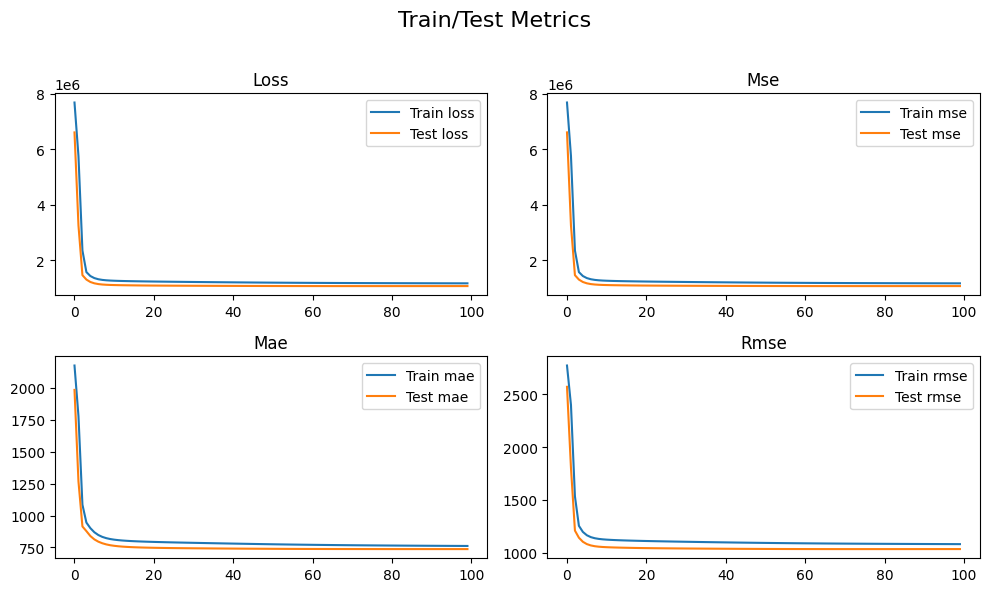

In [20]:
plot_metrics(metrics)